In [3]:
import numpy as np      
from netCDF4 import Dataset    
from scipy.spatial import cKDTree
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt

In [4]:
# geolocation
geo = np.load("/gws/nopw/j04/cocoon/SSA_domain/lat_lon_2268_2080.npz")
lons_core = geo["lon"]
lats_core = geo["lat"]

# load some data
core = Dataset("/gws/nopw/j04/cocoon/SSA_domain/ch9_wavelet/2020/07/202007110800.nc")["cores"][0]

In [5]:
assert core.shape == lons_core.shape == lats_core.shape 
print(core.shape)

(2080, 2268)


# Getting spatial resolution

In [6]:
# Earth radius in km
R = 6371.0

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# choose a representative point near the centre
i = lats_core.shape[0] // 2
j = lats_core.shape[1] // 2

# meridional spacing (north–south)
dy = haversine(
    lats_core[i, j], lons_core[i, j],
    lats_core[i+1, j], lons_core[i+1, j]
)

# zonal spacing (east–west)
dx = haversine(
    lats_core[i, j], lons_core[i, j],
    lats_core[i, j+1], lons_core[i, j+1]
)

print(f"dy (N–S spacing): {dy:.2f} km")
print(f"dx (E–W spacing): {dx:.2f} km")

dy (N–S spacing): 3.05 km
dx (E–W spacing): 3.09 km


# Cropping class

In [7]:
class GeoGrid:

    def __init__(
        self,
        lats,
        lons,
        lat_min,
        lat_max,
        lon_min,
        lon_max,
        fill_value=-999.999
    ):

        self.fill_value = fill_value

        self.lats, self.lons, self.area, self.y0, self.y1, self.x0, self.x1 = \
            self._crop_with_area(
                lats, lons,
                lat_min, lat_max,
                lon_min, lon_max
            )

        self.Ny, self.Nx = self.lats.shape

        points = np.column_stack([
            self.lats.ravel(),
            self.lons.ravel()
        ])

        self.tree = cKDTree(points)


    def _crop_with_area(
        self,
        lats,
        lons,
        lat_min,
        lat_max,
        lon_min,
        lon_max
    ):

        lats_nan = np.where(lats == self.fill_value, np.nan, lats)
        lons_nan = np.where(lons == self.fill_value, np.nan, lons)

        mask = (
            (lats_nan >= lat_min) &
            (lats_nan <= lat_max) &
            (lons_nan >= lon_min) &
            (lons_nan <= lon_max)
        )

        rows = np.where(mask.any(axis=1))[0]
        cols = np.where(mask.any(axis=0))[0]

        y0, y1 = rows[0], rows[-1]
        x0, x1 = cols[0], cols[-1]

        lats_crop = lats[y0:y1+1, x0:x1+1]
        lons_crop = lons[y0:y1+1, x0:x1+1]

        R = 6371.0

        lat_rad = np.deg2rad(lats_crop)
        lon_rad = np.deg2rad(lons_crop)

        dlat = np.gradient(lat_rad, axis=0)
        dlon = np.gradient(lon_rad, axis=1)

        dy = R * dlat
        dx = R * np.cos(lat_rad) * dlon

        area = np.abs(dx * dy)

        return lats_crop, lons_crop, area, y0, y1, x0, x1


    def crop(self, field):
        return field[self.y0:self.y1+1, self.x0:self.x1+1]


    def query(self, lat, lon):
        _, idx = self.tree.query([lat, lon])
        return np.unravel_index(idx, (self.Ny, self.Nx))

    def query_many(self, lat, lon):
        pts = np.column_stack([lat, lon])
        _, idx = self.tree.query(pts)
        return np.unravel_index(idx, (self.Ny, self.Nx))

In [8]:
CONTEXT_LAT_MIN = 5
CONTEXT_LAT_MAX = 20
CONTEXT_LON_MIN = -20
CONTEXT_LON_MAX = -4

extent = (
    CONTEXT_LAT_MIN, CONTEXT_LAT_MAX,
    CONTEXT_LON_MIN, CONTEXT_LON_MAX
)

## Crop main data as well as lat, lon meshgrids

In [9]:
grid_core = GeoGrid(lats_core, lons_core, *extent)

In [10]:
lats_core_cropped = grid_core.lats
lons_core_cropped = grid_core.lons
core_cropped = grid_core.crop(core)

In [11]:
assert core_cropped.shape == lats_core_cropped.shape == lons_core_cropped.shape 
print(core_cropped.shape)

(532, 578)


# Compute SSIM and FSS

In [12]:
def compute_fss_binary(a, b, window):
    af = uniform_filter(a, size=window, mode="constant")
    bf = uniform_filter(b, size=window, mode="constant")

    num = np.mean((af - bf) ** 2)
    den = np.mean(af**2 + bf**2)

    if den == 0:
        return 1.0

    return 1 - num / den


In [13]:
def fss_matrix(field, thresholds, windows):
    out = np.zeros((len(thresholds), len(windows)))

    for i, thr in enumerate(thresholds):

        bin_ref = (field > 0).astype(float)
        bin_thr = (field >= thr).astype(float)

        for j, w in enumerate(windows):
            out[i, j] = compute_fss_binary(bin_ref, bin_thr, w)

    return out

In [17]:
percentiles = [70, 80, 85, 90, 95, 98]

def percentile_thresholds(field, percentiles):
    valid = field[field > 0]
    return [np.percentile(valid, p) for p in percentiles]

In [18]:
def fss_percentile_matrix(field, percentiles, windows):

    thresholds = percentile_thresholds(field, percentiles)
    ref_bin = (field > 0).astype(float)

    F = np.zeros((len(percentiles), len(windows)))

    for i, thr in enumerate(thresholds):

        bin_thr = (field >= thr).astype(float)

        for j, w in enumerate(windows):
            F[i, j] = compute_fss_binary(ref_bin, bin_thr, w)

    return F, thresholds


In [20]:
percentiles = [70, 80, 85, 90, 95, 98]
windows = [3, 9, 25, 49, 81, 121]
PIXEL_SIZE_KM = 3

F, thr_vals = fss_percentile_matrix(core_cropped, percentiles, windows)

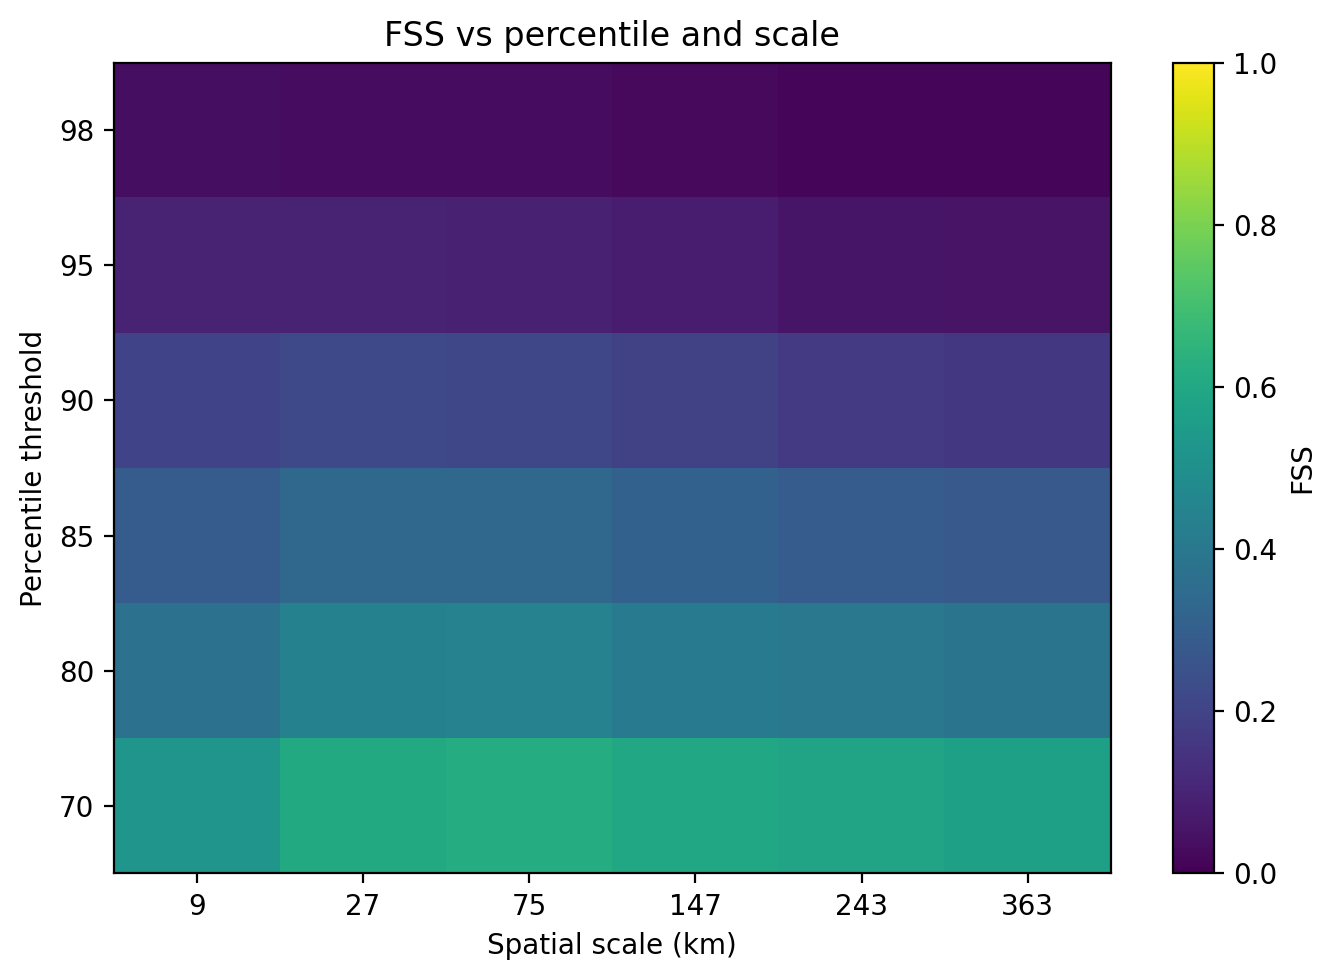

In [21]:
scales_km = [w * PIXEL_SIZE_KM for w in windows]

plt.figure(figsize=(7, 5), dpi=200)

im = plt.imshow(F, origin="lower", aspect="auto", vmin=0, vmax=1)

plt.xticks(range(len(windows)), scales_km)
plt.yticks(range(len(percentiles)), percentiles)

plt.xlabel("Spatial scale (km)")
plt.ylabel("Percentile threshold")
plt.title("FSS vs percentile and scale")

cbar = plt.colorbar(im)
cbar.set_label("FSS")

plt.tight_layout()
plt.show()

# SSIM

In [22]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim(a, b, win):
    return ssim(
        a,
        b,
        win_size=win,
        data_range=1.0,
        gaussian_weights=True
    )

In [23]:
def ssim_percentile_matrix(field, percentiles, windows):

    thresholds = percentile_thresholds(field, percentiles)
    ref_bin = (field > 0).astype(float)

    S = np.zeros((len(percentiles), len(windows)))

    for i, thr in enumerate(thresholds):

        bin_thr = (field >= thr).astype(float)

        for j, w in enumerate(windows):

            # SSIM window must be odd
            if w % 2 == 0:
                w += 1

            S[i, j] = compute_ssim(ref_bin, bin_thr, w)

    return S, thresholds


In [25]:
percentiles = [70, 80, 85, 90, 95, 98]
windows = [3, 9, 25, 49, 81]   # odd preferred

S, thr_vals = ssim_percentile_matrix(core_cropped, percentiles, windows)

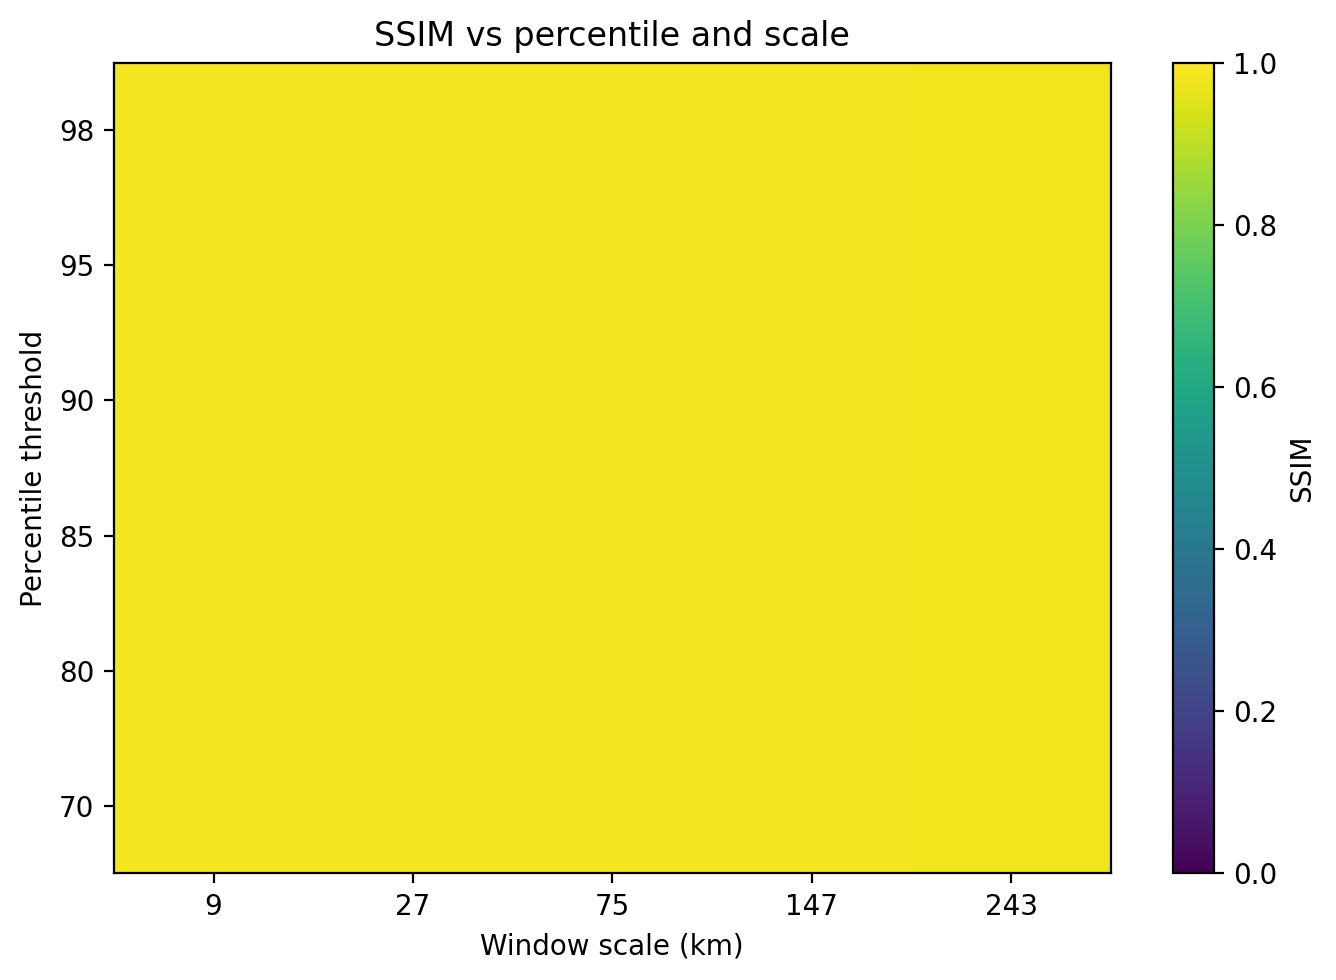

In [26]:
PIXEL_SIZE_KM = 3
scales_km = [w * PIXEL_SIZE_KM for w in windows]

plt.figure(figsize=(7, 5), dpi=200)

im = plt.imshow(
    S,
    origin="lower",
    aspect="auto",
    vmin=0,
    vmax=1
)

plt.xticks(range(len(windows)), scales_km)
plt.yticks(range(len(percentiles)), percentiles)

plt.xlabel("Window scale (km)")
plt.ylabel("Percentile threshold")
plt.title("SSIM vs percentile and scale")

cbar = plt.colorbar(im)
cbar.set_label("SSIM")

plt.tight_layout()
plt.show()
